## Q1

### Simulating a flight check-in counter

It is your job to simulate a flight-checkin counter. There are m agents handling n passengers. The passengers arrive in line with in-between time given by an exponential distribution for INTER_ARRIVAL_TIME. Each passenger, once he or she gets to a counter, is processed in a time drawn from an exponential distribution with PROCESSING_TIME. 

Clearly, in the usual case of 3-4 agents and 200+ customers on a flight, the customer waits much longer. We have been hired by the airlines customer-relations group to see how many extra agents must we hire to reduce waiting times by how much.

We start by representing each customer by a co-routine, which starts with the `inline` event. The state changes to the `atcounter` event, and then `ptime` seconds later, to the `leaves` event. Notice how this customer "process" is stopped at the yield, until the customer can be handled.

In [1]:
import collections, random
Event = collections.namedtuple('Event', 'time cid action agent')
def customer_process(idee, start, ptime):
    t, agent = yield Event(start, idee, "inline", None)
    t, agent = yield Event(t, idee, "atcounter", agent)
    yield Event(t+ptime, idee, "leaves", agent)


            

The following function simply implements the draw from the exponential distribution for a given customer:

In [2]:
def duration(arr_time, service_time):
    return random.expovariate(1./arr_time), random.expovariate(1./service_time)


Here is out main simulation class. you will be filling in parts of this class.

The constructor sets up the simulation. Three queues are created, one for agents that become free, one priority queue for events so that they can be processed in the order recieved, and a backlog for queue for those customers waiting in line because no agent was available.

We set up all the customers in the constructor, with two dictionaries, one to hold the co-routines, and one to hold time metadata which we shall use to figure the average waiting time.

The `run` method is where all the action happens and is the one you will edit.

In [24]:
import queue
import logging
class Simulator:
    
    def __init__(self, n_agents, n_customers, INTER_ARRIVAL_TIME =1., PROCESSING_TIME=3., DEBUG=False ): 
        #queues
        self.free_agents = queue.Queue()
        self.backlog = queue.Queue()
        self.events=queue.PriorityQueue()
        #save the arguments
        self.n_customers = n_customers
        self.n_agents = n_agents
        self.intertime=INTER_ARRIVAL_TIME
        self.proctime=PROCESSING_TIME
        #dictionaries to hold customer process
        self.customers={}
        self.customer_meta={}
        self.logger = logging.getLogger("sim")
        if DEBUG:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.WARNING)
        #on the free_agents queue, we put all the agents, and thee time
        #they got free
        for i in range(n_agents):
            self.free_agents.put((i,0))
        #this tracks when each customer came in.          
        time_when_came=0.
        for j in range(n_customers):
            interarrtime, proctime = duration(self.intertime, self.proctime)
            time_when_came += interarrtime
            intuple = (j, time_when_came, proctime)
            c = customer_process(*intuple)
            self.logger.debug("Customer {}, arrived {}, will take {} at counter".format(*intuple))
            #add each customer to dictionaries
            self.customers[j]=c
            self.customer_meta[j]={'cid':j, 'start':time_when_came, 'finish':None}
        self.logger.debug("========ending init==============\n\n")
        self.max_time_when_came=time_when_came  

    def run(self, end_time):
        #we prime each customer co-routine at the start
        #and put that event in the events priority queue
        #Since an event is a tuple, the ordering will be by start time
        for cid, proc in sorted(self.customers.items()):
            first_event = next(proc)#prime
            self.events.put(first_event)#customer in line
            

        #start at time 0
        sim_time = 0
        while sim_time < end_time:
            #we are done if no events and no backlog
            if self.events.empty() and self.backlog.empty(): 
                self.logger.debug('*** end of events and backlog***') 
                break
            #if we have agents available and a backlog
            #take customer from backlog queue. This is equivalent
            #to taking customers from line
            if not self.backlog.empty() and not self.free_agents.empty():
                "YOUR CODE HERE"
                current_event = self.backlog.get()
                switch = 1
                #the sim time from this branch will be false
                #as we get the old time the person in the line showed up
            else: #get current event in all other cases
                #his ensures that leave events are processed thus
                #freeing up agents
                "YOUR CODE HERE"
                current_event = self.events.get()
                switch = 0
            
            sim_time, cid, action, agent = current_event
            #get the current customer process
            cproc = self.customers[cid]
                
            if action=='leaves':
                self.logger.debug(">>>Customer {} leaves, agent {} free at {}".format(cid, agent, sim_time))
                #an agent gets free. Put the time they got free on q
                #also update the metadata
                self.free_agents.put((agent, sim_time))
                self.customer_meta[cid]['finish']=sim_time
            elif action=='atcounter':
                self.logger.debug("Customer {} atcounter Agent {} at {}".format(cid, agent, sim_time))
                next_time = sim_time#processing time already in coroutine
            elif action=='inline':#the agent is None to start
                self.logger.debug('----------------------------------------------')
                self.logger.debug("Customer {}, arrived in line @ {}.".format(cid, sim_time))

                if self.free_agents.empty():
                    self.logger.debug("NO agents available, putting {} inline on backlog at {}".format(cid, sim_time))
                    "YOUR CODE HERE"
                    self.backlog.put(current_event)
                    continue
                else:
                    self.logger.debug("{} agents available to serve.".format(self.free_agents.qsize()))
                    "YOUR CODE HERE"#handle both situations
                    #of getting from backlog or regular. The time in
                    #next_time which you will send in message to co-routine
                    #below are different
                    if switch == 0:
                        next_time = sim_time
                        agent, t = self.free_agents.get()
                    else:
                        agent, next_time = self.free_agents.get()
                        
                    self.logger.debug("Customer {} inline to be served by Agent {} at {}".format(cid, agent, next_time))
            #drive the co-routine by sending in time and agent, and getting
            #next event out. The event is put into the priority queue.
            try:
                next_event = cproc.send((next_time, agent)) 
            except StopIteration:
                del self.customers[cid] 
            else:
                self.events.put(next_event)
                
    def compute_ptimes(self):
        ptimes=[]
        for j in range(self.n_customers):
            #print(j,self.customer_meta[j] )
            if self.customer_meta[j]['finish']!=None:
                ptimes.append(self.customer_meta[j]['finish'] - self.customer_meta[j]['start'])
        return ptimes

In [25]:
def sim_main(num_agents, num_customers, extratime=20., seed=None, debug=False):
    if seed is not None:
        random.seed(seed)
    sim = Simulator(num_agents, num_customers, DEBUG=debug)
    sim.run(sim.max_time_when_came+extratime)
    return sim

Start small to test this out.

In [26]:
sim=sim_main(2,6, debug=True)

DEBUG:sim:Customer 0, arrived 0.5542225205353248, will take 0.8951774908812957 at counter
DEBUG:sim:Customer 1, arrived 0.9342150551071102, will take 0.15826491687023425 at counter
DEBUG:sim:Customer 2, arrived 3.781656120019022, will take 3.909530614754469 at counter
DEBUG:sim:Customer 3, arrived 5.080281230079131, will take 6.971641444714644 at counter
DEBUG:sim:Customer 4, arrived 5.403747069934065, will take 7.295621458446274 at counter
DEBUG:sim:Customer 5, arrived 5.5623390587761214, will take 2.0265061251646244 at counter
DEBUG:sim:========ending init==============


DEBUG:sim:----------------------------------------------
DEBUG:sim:Customer 0, arrived in line @ 0.5542225205353248.
DEBUG:sim:2 agents available to serve.
DEBUG:sim:Customer 0 inline to be served by Agent 0 at 0.5542225205353248
DEBUG:sim:Customer 0 atcounter Agent 0 at 0.5542225205353248
DEBUG:sim:----------------------------------------------
DEBUG:sim:Customer 1, arrived in line @ 0.9342150551071102.
DEBUG:sim:1

Now lets try it with some larger numbers.

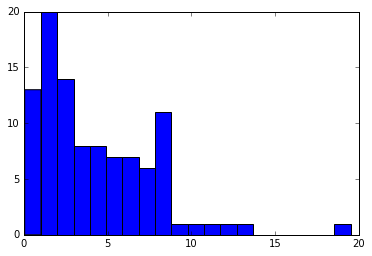

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
sim=sim_main(3,100)
plt.hist(sim.compute_ptimes(), bins=20);

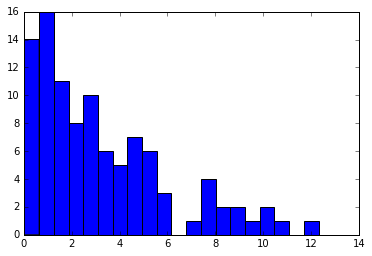

In [28]:
sim2=sim_main(4,100)
plt.hist(sim2.compute_ptimes(), bins=20);

extra time needed below as with 400 passengers a long time is taken to process.

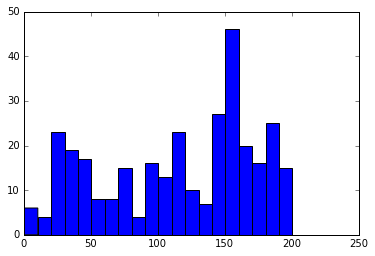

In [29]:
sim2=sim_main(2,400, extratime=100)
plt.hist(sim2.compute_ptimes(), bins=20);

For a proper statistical analysis, you would want to draw this multiple times and look at the distribution of the averages as well. But you should know what this distribution is :-).